## Tutorial 4: Continuous degradation modelling, Prognostics and Remaining Useful Life


In [1]:
## IMPORT
import numpy as np
import matplotlib.pyplot as plt

Description of the model and the assumptions

- We consider an item which is inspected every 15 months (perInsp$=15$) and the total number of inspections is 35 (nInsp$=35$).


- We consider the degradation model $X(t)$ which is deterministic:
$$
X(t) = 0.01\,t+0.01\,t^2
$$


- The observation $Y(t)$ of $X(t)$ is defined as $Y(t) = X(t)+\epsilon(t)$ where $\epsilon(t)$ is a Gaussian noise (ie. a noise having a normal pdf with mean and standard deviation respectively equal to 0 and $\sigma$).


- The item is considered to be failed when $Y(t)$ reaches a level L.



We first define all the parameters we need

In [2]:
## PARAMETERS

# `mdl`is a dictionary to define the model Y(t)
mdl = {}
# Parameters for X(t) function
mdl['para'] = np.array([0.01, 0.01])
# Mean of the noise
mdl['muEps'] = 0
# Standard deviation of the noise
mdl['sigEps'] = 100

# Period of inspection
perInsp = 15
# Number of inspections
nInsp = 35
# Vector time of inspections
vTime = np.arange(0, (nInsp+1)*perInsp, perInsp, dtype=float)

# Failure level
L = 5000
# Time to end the simulation of one path of Y(t) - Should be large enough to be sure that Y(t) overpasses L
tEnd = 1000
# Prediction horizon for the RUL: from the last inspection date `vTime[-1]+1` to `tEnd` with time step `1`
vTimeProj = np.arange(vTime[-1]+1, tEnd, 1, dtype=float)

# Number of trajectories for projection simulation
nRnd = 1000


We creat a function GetState that simulates a given number of paths of $Y(t)$ 

- First we calculate the values of $X(t)$ at any times in vTime. This is put in vStateExact


- Second we duplicate $X(t)$ to prepare for the number of simulated paths we want (nbHist)


- Third we add the random noise at any times to all duplicated $X(t)$, in order to get nbHist path of $Y(t)$. This is put is mState. This is a matrix with nbHist columns. One path is in a column. The number of lignes is the number of inspections.


- As output, we keep  vStateExact and mState.


In [3]:
# GetState is the function that generates `nbHist` paths of Y(t)
def GetState(mdl, vTime, nbHist):
    # Duplicate vTime
    mTime = np.tile(np.asmatrix(vTime).T, (1, mdl['para'].shape[0]))
    # Calculate the power of t 
    mTime = np.power(mTime, range(1, mdl['para'].shape[0]+1))
    # Calculate X(t) by applying a product of matrixes
    vStateExact = mTime@(np.asmatrix(mdl['para']).T)
    # Duplicate X(t)
    mStateExact = np.tile(vStateExact, (1, nbHist))
    # Simulate Y(t)
    mState = mStateExact+np.random.normal(loc=mdl['muEps'], scale=mdl['sigEps'], size=mStateExact.shape)
    # mState[mState<0] = 0
    return vStateExact, mState

We use GetState to simulate one path of $Y(t)$

- $Y(t)$ is in vObs for any time $t$ in vTime, that is to say from $0$ to the last inspection date, at every inspection date.

- $X(t)$ is in vState for any time $t$ in vTime

In [4]:
## History simulation: simulate the learning data set - `vState` is X(t) and `vObs` is Y(t)
vState, vObs = GetState(mdl, vTime, 1)

We plot the obtained path of $Y(t)$ in black and the curve for $X(t)$ in red from $0$ to the last inspection date


Text(0, 0.5, 'Degradation')

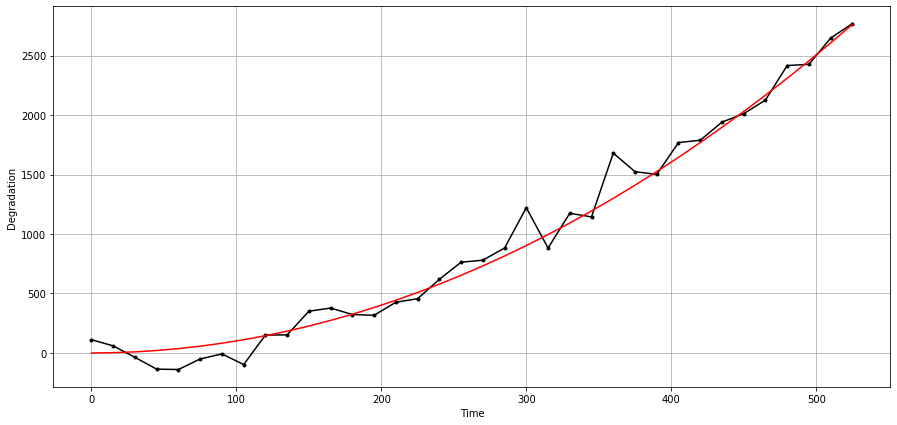

In [5]:
## History visualization: plot the data set, this is one path (X(t) is red, Y(t) with noise is black)
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(vTime, vObs, '-k.')
ax.plot(vTime, vState,'-r');
ax.grid(True)
ax.set_xlabel('Time')
ax.set_ylabel('Degradation')


We consider now that one simulated path of $Y(t)$=vObs is a vector of observations, which is collected in the past, from time $0$ to the last inspection time. This is a learning data set.

We creat a function to use it to estimate the parameters of the model.

- We compute mean least square method to estimate parameters of $X(t)$. This is put in mdlEst['para'].


- We estimate empirically the parameters of the noise $\epsilon(t)$. This is put in mdlEst['muEps'] and  mdlEst['sigEps']


- As output, we get mdlEst


In [6]:
# Estimation of the model parameters with mean least square method: vObs=mTime.mdlpara
def GetMdlEst(vTime, vObs):
    mdlEst = {}
    mTime = np.tile(np.asmatrix(vTime).T, (1, mdl['para'].shape[0]))
    mTime = np.power(mTime, range(1, mdl['para'].shape[0]+1))
    # mdlpara is the solution of the mean least square estimation
    mdlpara = (np.linalg.inv(mTime.T@mTime)@mTime.T*vObs).T
    # mdlEst is for putting mdlpara in the same format as mdl (1 column vector)
    mdlEst['para'] = np.asarray(mdlpara)[0]
    vObsEst = mTime@(mdlpara.T)
    # Estimation of the noise parameters
    mdlEst['muEps'] = np.mean(vObs-vObsEst)
    mdlEst['sigEps'] = np.std(vObs-vObsEst)
    return mdlEst 

We apply the function to the simulated path $Y(t)$ which is in Vobs

In [7]:
## Model identification: estimate the parameters of X(t): i.e. 0.01 and 0.01 (noise variance is supposed to be known.
mdlEst = GetMdlEst(vTime, vObs)
print('Para: {}'.format(mdlEst['para']))
print('muEps: {}'.format(mdlEst['muEps']))
print('sigEps: {}'.format(mdlEst['sigEps']))

Para: [0.14946854 0.00992559]
muEps: -10.964145578980158
sigEps: 113.19126095933196


We consider now that the model parameters have been estimated on the learning data set with one path and we use the model to make predictions.

- We simulate $Y(t)$ from the last inspection date to tEnd  by using the estimated parameters of $X(t)$ and of the noise as input for the function GetState


- The number of simulated paths for $Y(t)$ is nRnd. We can simulated as much as path as we want on order to assess the uncertainty of the prediction.


- The obtained $X(t)$ is in VstateEst and the obtained $Y(t)$ is in mEst


- $X(t)$ and $Y(t)$ are calculated/simulated from the lastinspection date to tEnd with a given time step, that is to say for every times that are given in vTimeProj



In [8]:
## Model prediction

vStateEst, mEst = GetState(mdlEst, vTimeProj, nRnd)

As a reference to make comparison, we make prediction with the true values of the model

In [9]:
## Theoretical prediction

# Calculate the values of X(t) with the true parameters from the last inspection date to 750.
vStateProj, vObsProj = GetState(mdl, vTimeProj, 1)

We plot the path from the learning data set and the paths for the prediction

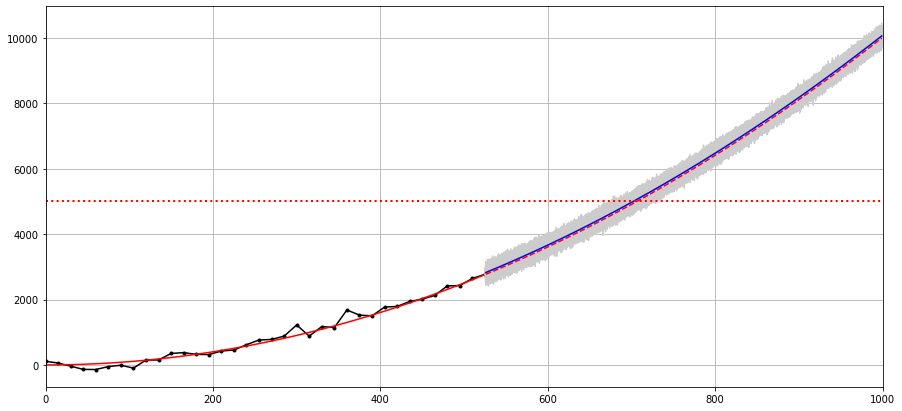

In [10]:
## Projections visualization 

# Plot the simulated path of Y(t) and the calculated path of X(t) from the last inspection date to
# 750 that have been used to generate the learning data set
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(vTime, vObs, '-k.')
ax.plot(vTime, vState, '-r')
# plot 
# i) Y(t) simulated with the estimated parameters of X(t)
ax.plot(vTimeProj, mEst, color=[0.8, 0.8, 0.8])
# ii) X(t) calculated with estimated parameters
ax.plot(vTimeProj, vStateEst, 'b')
# iii) X(t) calculated with the true parameters from the last inspection date to 750
ax.plot(vTimeProj, vStateProj, '--r');
ax.plot([0, tEnd], [L, L], 'r:', LineWidth=2)
ax.set_xlim([0, tEnd])
ax.grid(True)

We calculate the hitting time of the failure level 

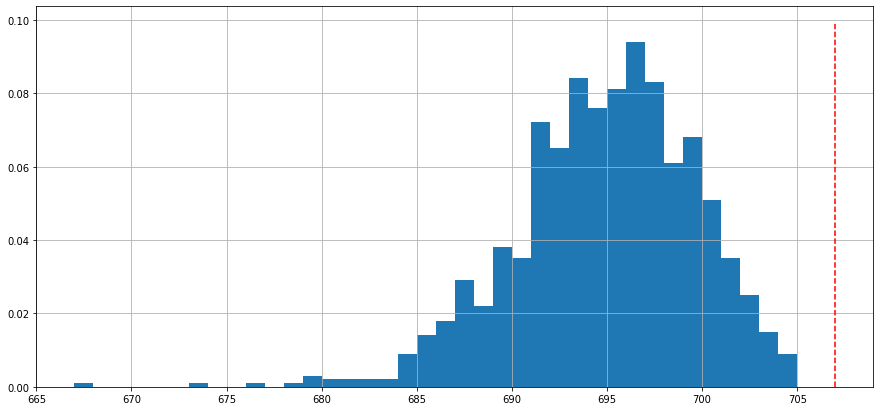

In [11]:
## Hitting time calculation

# Calculate the time upon which the failure level L is reached.
# This can be done with: 
# i) Y(t) simulated with the estimated parameters of the model 
mTimeProj = np.tile(np.asmatrix(vTimeProj).T, (1, nRnd))
mTimeProj[mEst<L] = np.Inf # if Y(t) is below the failure level L, it is put to infinite
vTimeL = np.min(mTimeProj, axis=0).T
# ii) the true model X(t) used to simulate the data.
vTimePorjTmp = np.asmatrix(vTimeProj).T
vTimePorjTmp[vStateProj<L] = np.inf
timeL = np.min(vTimeProj);

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.hist(vTimeL, bins=range(int(np.floor(np.min(vTimeL))), int(np.ceil(np.max(vTimeL)))), density=True)
#ax.hist(vTimeL, bins=range(int(np.floor(np.min(vTimeL))), int(np.ceil(np.max(vTimeL)))), density=True)
ax.grid(True)
ylim = ax.get_ylim()
ax.plot([timeL, timeL], ylim, 'r--')